In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.functional import F
from torchvision.transforms import functional
import random
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision
from time import time
import torch.optim.lr_scheduler as S
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda'

test_set = torchvision.datasets.MNIST(root = 'data/', train = False, download = True)
test_input = test_set.data.view(-1, 1, 28, 28).float().to(device)
test_targets = test_set.targets.to(device)

mu, std = test_input.mean(), test_input.std()
test_input.sub_(mu).div_(std)

train_set = torchvision.datasets.MNIST(root = 'data/', train = True, download = True)
train_input = train_set.data.view(-1, 1, 28, 28).float()
train_targets = train_set.targets

In [4]:
class mLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(mLeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        last_channel = 16
        self.conv3 = nn.Conv2d(16, last_channel, 2)
        self.use_bn = use_bn
        if self.use_bn:
            self.conv1_bn = nn.BatchNorm2d(6)
            self.conv2_bn = nn.BatchNorm2d(16)
            self.conv3_bn = nn.BatchNorm2d(last_channel)

        self.fc3 = nn.Linear(last_channel, 10)

    def forward(self, x):
        if self.use_bn:
            x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
            x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
            x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), 2)
        else:
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train_model(use_bn = False, lr = 0.005, optimize_method = torch.optim.SGD, seed = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    device = 'cuda'
    nb_epochs, batch_size = 3000, 32

    model = mLeNet(use_bn = use_bn)
    model.to(device)
    #optimizer = optimize_method(model.parameters(), lr = lr, momentum = momentum )
    optimizer = optimize_method(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = S.StepLR(optimizer, step_size=200, gamma=1)

    train_len, attack_len = 512, 512
    lbd = 0.2

    test_acc = []
    train_acc = []
    l_list = []

    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    attack_x, attack_y = train_input[train_len:train_len + attack_len].to(device), train_targets[train_len:train_len + attack_len].to(device)
    mu, std = attack_x.mean(), attack_x.std()
    attack_x.sub_(mu).div_(std)

    mylist = list(range(10))
    for i in range(attack_len):
        n = mylist[:]
        n.remove(attack_y[i])
        attack_y[i] = random.choice(n)


    train_batches = math.ceil(train_len/batch_size)

    for e in tqdm(range(nb_epochs)):
        ite = 0
        for input, targets in zip(train_x.split(batch_size) + attack_x.split(batch_size),train_y.split(batch_size) + attack_y.split(batch_size)):
        
        #for input, targets in zip(train_x.split(batch_size),train_y.split(batch_size)):
            output = model(input)
            ite += 1
            if ite<=train_batches:
                loss = criterion(output, targets)
            else:
                loss = lbd*criterion(output, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            out = model(train_x)
            _, predicted_classes = out.max(1)
            _, predicted_classes_test = model(test_input).max(1)

            l = criterion(out, train_y).item()
            test_a = (predicted_classes_test == test_targets).to(float).mean().item()
            train_a = (predicted_classes == train_y).to(float).mean().item()

            l_list.append(l)
            test_acc.append(test_a)
            train_acc.append(train_a)
            
            if (e>=500) and (all(i >= 2 for i in l_list[-10:])):
                return model,"diverge"
                break
            
            print("epoch: %i, loss: %.4f, train_acc: %.4f, test_acc: %.4f" %(e+1,l,train_a,test_a))
            stats = [e+1,l,train_a,test_a]
            if l <= 0.001:
                return model,stats
                break
    return model,stats

In [18]:
optimize_method = torch.optim.Adam
use_bn = False
lr = 0.005
stats_data = np.empty([2,20],dtype=object)
use_bn_list = [False,True]

for ii,use_bn in enumerate(use_bn_list):
    for seed in range(20):
        print(use_bn, seed)
        my_model,stats_data[seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed)
        np.save("experiment_results/stats_data_adamBN.npy",stats_data)

False 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 2.2383, train_acc: 0.2266, test_acc: 0.1765
epoch: 2, loss: 2.0429, train_acc: 0.3555, test_acc: 0.2972
epoch: 3, loss: 1.6231, train_acc: 0.5449, test_acc: 0.4611
epoch: 4, loss: 1.4148, train_acc: 0.5547, test_acc: 0.5049
epoch: 5, loss: 1.3883, train_acc: 0.5645, test_acc: 0.4904
epoch: 6, loss: 1.6412, train_acc: 0.3652, test_acc: 0.3206
epoch: 7, loss: 1.0977, train_acc: 0.7051, test_acc: 0.6187
epoch: 8, loss: 1.1603, train_acc: 0.7168, test_acc: 0.6071
epoch: 9, loss: 1.0263, train_acc: 0.7852, test_acc: 0.6945
epoch: 10, loss: 0.9400, train_acc: 0.8281, test_acc: 0.7274
epoch: 11, loss: 0.8250, train_acc: 0.8516, test_acc: 0.7352
epoch: 12, loss: 0.8569, train_acc: 0.8359, test_acc: 0.7382
epoch: 13, loss: 0.6919, train_acc: 0.8887, test_acc: 0.7764
epoch: 14, loss: 0.7843, train_acc: 0.8516, test_acc: 0.7433
epoch: 15, loss: 0.7245, train_acc: 0.8691, test_acc: 0.7473
epoch: 16, loss: 0.8065, train_acc: 0.8203, test_acc: 0.7097
epoch: 17, loss: 0.9642, train_ac

KeyboardInterrupt: 

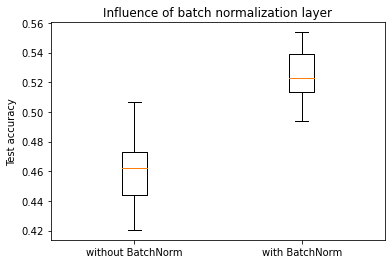

In [20]:
stats_data_adamBN = np.load("experiment_results/stats_data_adamBN.npy", allow_pickle=True)

plt.boxplot([[x[-1] for x in stats_data_adamBN[0]],[x[-1] for x in stats_data_adamBN[1]]])
plt.xticks([1, 2], ['without BatchNorm', 'with BatchNorm'])
plt.ylabel("Test accuracy")
plt.title('Influence of batch normalization layer')
plt.savefig("figures/bn.png",dpi=200,bbox_inches='tight')